In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
     image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    #dataset.take(1): This method is used to take one batch from the dataset. It limits the iterator to a single batch.
#for image_batch, labels_batch in dataset.take(1): This loop extracts one batch of images and labels from the dataset.
#image_batch: This variable holds a batch of images.
#labels_batch: This variable holds a batch of class labels corresponding to the images.
#Output Explanation
#print(image_batch.shape)
#(32, 256, 256, 3): This line prints the shape of image_batch.
#32: The batch size, meaning there are 32 images in this batch.
#256, 256: The height and width of each image, indicating that the images are 256x256 pixels.
#3: The number of color channels in each image, which is typical for RGB images (red, green, blue).
#print(labels_batch.numpy())
#[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]: This line prints the numpy array of class labels for the batch.
#Each number in the array represents the class label for the corresponding image in the batch.
#Since there are 32 images, there are 32 labels.
#The labels are typically integers representing different classes, such as:
#0: Could represent one class (e.g., cats).
#1: Could represent another class (e.g., dogs).
#2: Could represent another class (e.g., birds).

(32, 256, 256, 3)
[1 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1]


#Visualize some of the images from our dataset


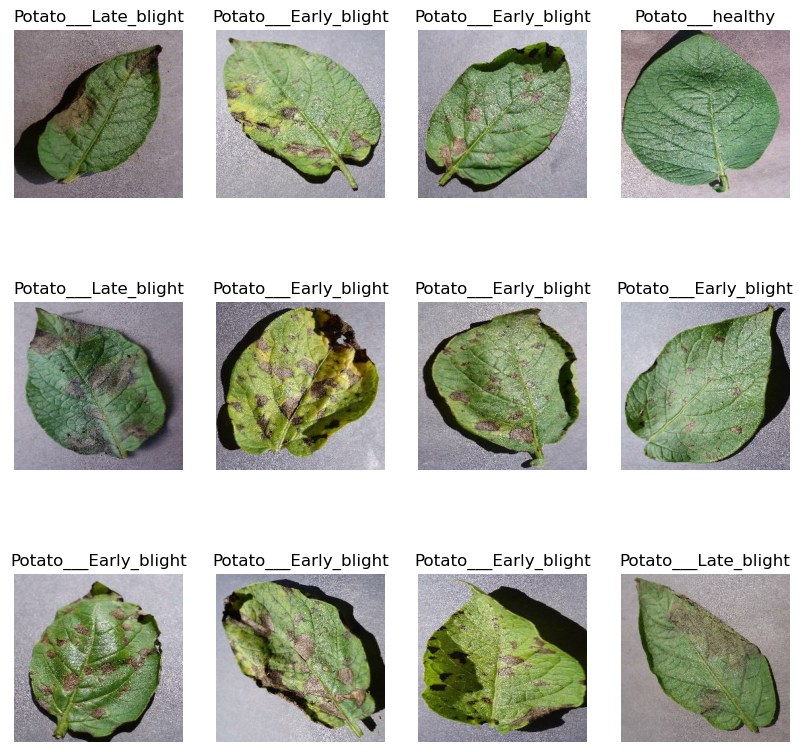

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
# Original dataset length
print(len(list(dataset)))  # Should print 68

68


In [12]:
# Splitting the dataset
train_size = 0.8
train_len = int(len(list(dataset)) * train_size)
train_ds = dataset.take(train_len)
print(len(list(train_ds)))  # Should print 54



54


In [13]:
test_ds = dataset.skip(train_len)
print(len(list(test_ds)))  # Should print 14



14


In [14]:
val_size = 0.1
val_len = int(len(list(dataset)) * val_size)
val_ds = test_ds.take(val_len)
print(len(list(val_ds)))  # Should print 6



6


In [15]:
test_ds = test_ds.skip(val_len)
print(len(list(test_ds)))  # Should print 8

8


In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)


54

In [19]:
len(val_ds)


6

In [20]:
len(test_ds)


8

#Cache, Shuffle, and Prefetch the Dataset


In [21]:
import tensorflow as tf

# Define buffer size for prefetching
buffer_size = 2  # Adjust according to your system capabilities

# Assuming train_ds, val_ds, test_ds are your TensorFlow datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=buffer_size)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=buffer_size)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=buffer_size)

#cache():

#This operation caches the dataset in memory (or on disk if specified) after the first iteration. This is useful when your dataset fits in memory, as it speeds up the data input pipeline by avoiding the need to read data from the source multiple times.
#Purpose: To improve the efficiency of the data pipeline by reducing the overhead of data loading and preprocessing.
#shuffle(buffer_size=1000):

#This operation randomly shuffles the elements of the dataset. The buffer_size parameter defines the size of the buffer from which elements are drawn to form the shuffled dataset. A larger buffer size leads to better shuffling but requires more memory.
#Purpose: To ensure that the data fed into the model during training is randomized. This helps in preventing the model from learning the order of the data and improves generalization.
#prefetch(buffer_size=tf.data.AUTOTUNE):

#This operation overlaps the data preprocessing and model execution. buffer_size=tf.data.AUTOTUNE allows TensorFlow to dynamically tune the prefetch buffer size to optimize performance.
#Purpose: To improve the efficiency of the training process by preparing the next batch of data while the current batch is being processed by the model, reducing idle time.

In [22]:
#Creating a Layer for Resizing and Normalization
#Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, 
#we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference.
#Hence we can add that as a layer in our Sequential Model.
#You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful 
#when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and
#this layer will resize it
# Sequential model for resizing and rescaling
import tensorflow as tf
from tensorflow.keras import layers

IMAGE_SIZE = (224, 224)  # Example size, adjust as needed

# Function to resize and rescale images
def preprocess_image(image):
    # Resize images to desired size
    resized_image = tf.image.resize(image, IMAGE_SIZE)
    # Rescale pixel values to [0, 1]
    normalized_image = tf.cast(resized_image, tf.float32) / 255.0
    return normalized_image

# Example of using Sequential API for preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.Lambda(preprocess_image)
    # Other layers can be added here
])


##**DATA AUGMENTATION**
#Original Image  ===>  ( Horizontal Flip / Contrast / / Rotation / Zoom )


In [23]:
import tensorflow as tf
from tensorflow.keras import layers

def apply_augmentation(image):
    # Random horizontal and vertical flipping
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random rotation
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image

data_augmentation = tf.keras.Sequential([
    layers.Lambda(lambda x: apply_augmentation(x)),
    # Add more layers as needed
])


In [24]:
buffer_size = 2  # Adjust based on your system and dataset size

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=buffer_size)

#train_ds is assumed to be a TensorFlow Dataset object containing your training data (x, y), where x represents input images and y represents labels.
#train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)) applies the data_augmentation sequence to each element (x, y) in the dataset. 
#The training=True argument ensures that the augmentation layers behave differently during training compared to evaluation or prediction, 
#where augmentation should not be applied.
#.prefetch(buffer_size=tf.data.AUTOTUNE) is used to prefetch data batches to improve training performance. 
#tf.data.AUTOTUNE dynamically adjusts the prefetch buffer size based on available memory and CPU resources.

In [25]:
from IPython.display import HTML


In [26]:
HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/mTVf7BN7S8w" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define constants
BATCH_SIZE = 32
IMAGE_SIZE = 224  # Example size, adjust as needed
CHANNELS = 3
n_classes = 3

# Define the resize and rescale layer (example)
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Define the input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Build the model
model = models.Sequential([
    layers.Input(shape=input_shape),  # Use Input layer to specify input shape
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Print model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,459 (669.76 KB)

 Trainable params: 171,459 (669.76 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,459 (669.76 KB)

 Trainable params: 171,459 (669.76 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.4505 - loss: 0.9799 - val_accuracy: 0.5677 - val_loss: 0.8843
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.6300 - loss: 0.7743 - val_accuracy: 0.7812 - val_loss: 0.4792
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.7886 - loss: 0.4918 - val_accuracy: 0.8073 - val_loss: 0.3665
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8536 - loss: 0.3285 - val_accuracy: 0.9219 - val_loss: 0.2443
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9040 - loss: 0.2436 - val_accuracy: 0.9323 - val_loss: 0.1321
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9334 - loss: 0.1843 - val_accuracy: 0.9427 - val_loss: 0.1250
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9319 - loss: 0.1693 - val_accuracy: 0.9948 - val_loss: 0.0652
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9548 - loss: 0.1338 - val_accuracy: 0.9531 - val

In [32]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 487ms/step - accuracy: 0.9093 - loss: 0.2584


[0.29636213183403015, 0.89453125]

**Plotting the Accuracy and Loss Curves**


In [33]:
history
history.params
history.history.keys()
type(history.history['loss'])
len(history.history['loss'])
history.history['loss'][:5] # show loss for first 5 epochs


[0.9242369532585144,
 0.6809482574462891,
 0.4591650366783142,
 0.3137008547782898,
 0.2013804316520691]

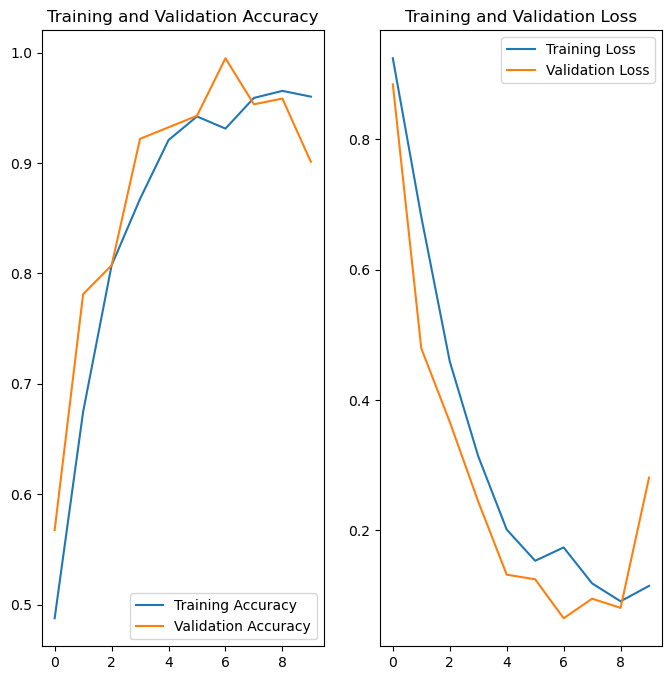

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

EPOCHS = len(acc)  # Set EPOCHS to the length of the history lists

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Run prediction on a sample image**

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
predicted label: Potato___Late_blight


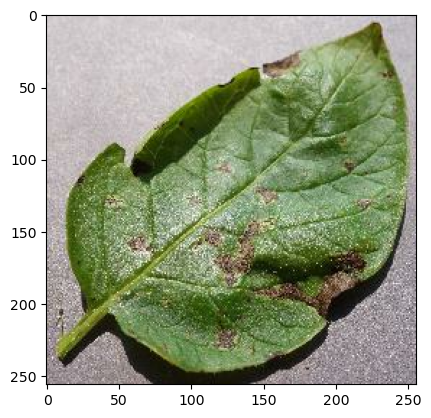

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


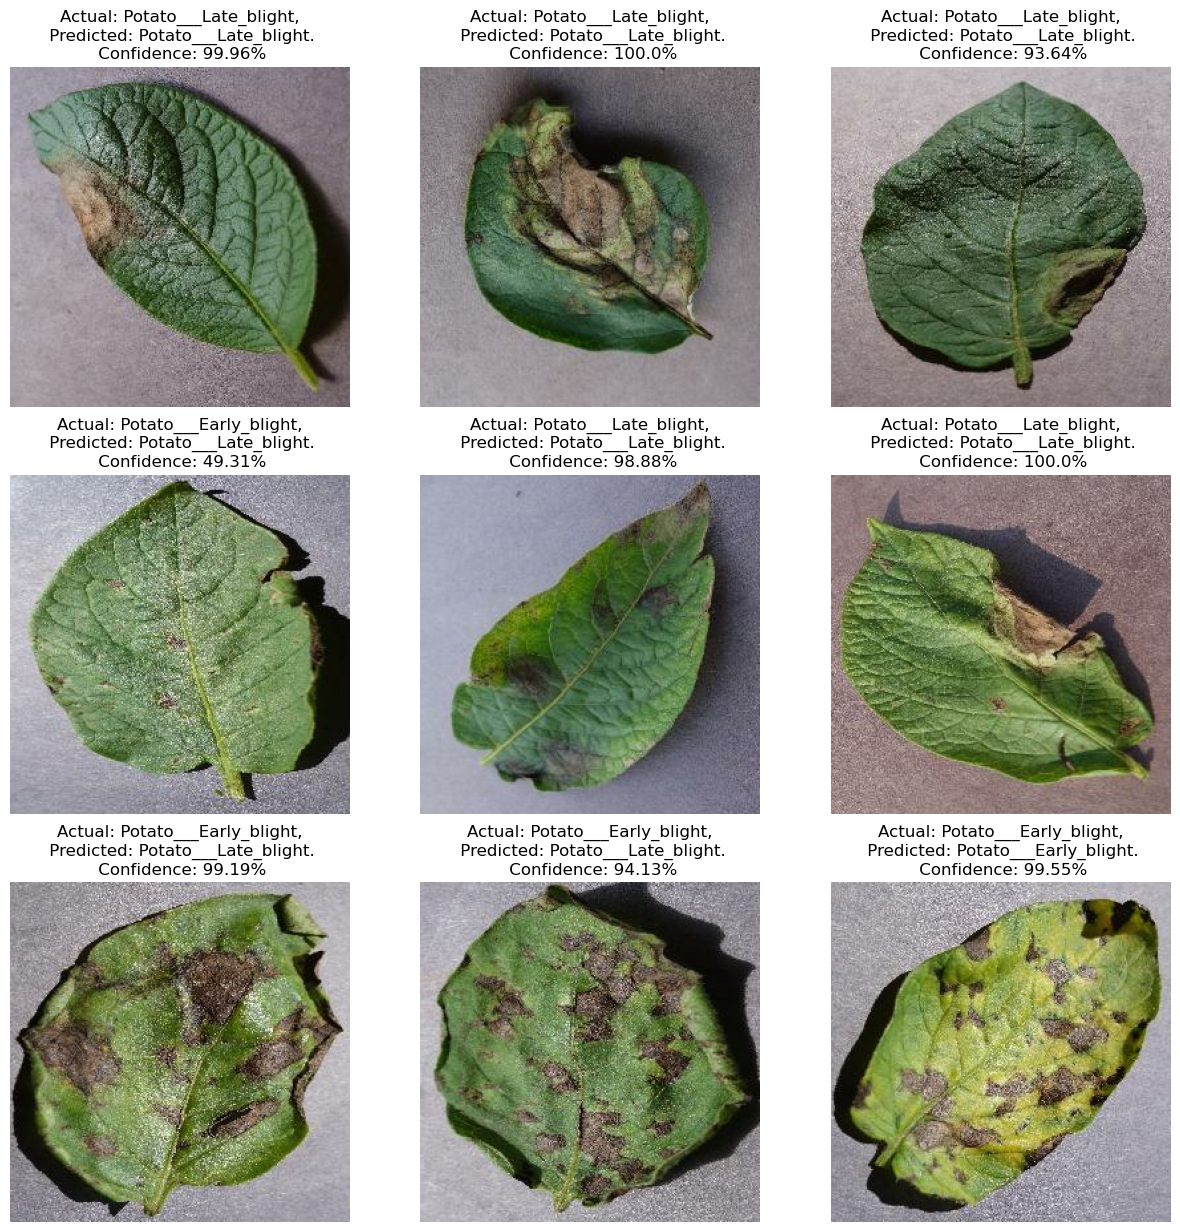

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

**Saving the Model**
We append the model to the list of models as a new version

In [42]:
# import os
# from tensorflow.keras.models import load_model

# model_version = 3
# models_dir = 'C:/Users/mouni/potato_disease/models'

# # Ensure the directory exists or create it
# os.makedirs(models_dir, exist_ok=True)

# # Save the model in .keras format
# model.save(os.path.join(models_dir, f'model_{model_version}.keras'))


In [43]:
# # Save the model in .keras format
# model.save(os.path.join(models_dir, f'model_{model_version}.keras'))


In [4]:
import tensorflow as tf

model = tf.keras.models.load_model("C:/Users/mouni/potato_disease/models/1/model_1.keras")
tf.saved_model.save(model, "C:/Users/mouni/potato_disease/models/saved_model/1")


INFO:tensorflow:Assets written to: C:/Users/mouni/potato_disease/models/saved_model/1\assets


INFO:tensorflow:Assets written to: C:/Users/mouni/potato_disease/models/saved_model/1\assets
